# Herron - Does momentum investing work?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.4f}'.format)
%precision 4
%config InlineBackend.figure_format = 'retina'

import yfinance as yf
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

## What is momentum investing?

From page 13 of [chapter 12](https://book.ivo-welch.info/read/source5.mba/12-effbehav.pdf) of Ivo Welch's free corporate finance textbook (***emphasis added***):

> The second-most important factor anomaly was the momentum investing strategy.
***Momentum investing strategies require going long in stocks that have increased
greatly over the last year, and going short in stocks that have decreased greatly.***
(It requires a few more contortions, but this is a reasonable characterization.) As
with value, behavioral finance researchers were quick to adopt momentum as a
consequence of investor psychology. They also developed plenty of theories that
argued about how the psychology of investors could explain momentum.
>
> Yet over the last 17 years, Ken French’s data suggests that the average rate of Momentum has been mostly
return on the momentum investment strategy was — drumroll — 0.03% with a
standard deviation of 23.8%. This rate of return is statistically and economically
insignificant. Momentum investing also had the unpleasant aspect of sudden nasty
risk. It lost 83 cents for every dollar invested in 2009

As a side note, I recommend this textbook as your first stop to learn about (almost) any finance topic.
Welch connects theory and practice better than other textbooks and provides his textbook for free!

## Download data from Yahoo! Finance

We need a large number of stocks to test momentum investing!
We will use the Russell 1000 Index constituents, about 93% of U.S. public equity by market capitalization.
We can easily find their tickers on [Wikipedia]() and easily download their data from Yahoo! Finance.

In [2]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/Russell_1000_Index')
tickers = wiki[2]['Ticker'].replace(to_replace='\.', value='-', regex=True).to_list()

In [3]:
# russ = yf.download(tickers=tickers, session=session)
# russ.columns.names = ['Variable', 'Ticker']
# russ.to_pickle('../../Data/russ.pkl')

# I saved russ.pkl in my "Data" folder
# You can save it to the same folder as your notebook and remove "../../Data/"
russ = pd.read_pickle('../../Data/russ.pkl') 

## Yahoo! Finance data have a survivorship bias!

Yahoo! Finance only provides data for listed (active) public companies.
When public companies delist, Yahoo! Finance removes their data from the website and API interfaces.
Companies delist for various reasons, including failures, poor performance, buyouts, and acquisitions.
Failures and poor performance are generally associated with large negative returns before delisting.
Buyouts and acquisitions are generally associated with large positive returns before delisting.
Regardless of the reason for delisting, delisted company data are unavailable from Yahoo! Finance.
The lack of delisted company data in data frame `russ` means that our analysis will have a [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias):

> Survivorship bias, survival bias or immortal time bias is the logical error of concentrating on the people or things that made it past some selection process and overlooking those that did not, typically because of their lack of visibility. This can lead to incorrect conclusions regarding that which (or those who) didn't make it.
>
> Survivorship bias is a form of selection bias that can lead to overly optimistic beliefs because multiple failures are overlooked, such as when companies that no longer exist are excluded from analyses of financial performance. It can also lead to the false belief that the successes in a group have some special property, rather than just coincidence as in correlation "proves" causality. For example, if 3 of the 5 students with their state's highest college GPAs went to the same high school, it might lead to the notion (which the institution may even capitalize on through advertising) that their high school offers an excellent education even though it's actually due to their school being the largest in their state. Therefore, by comparing the average GPA of all of the school's students — not just the ones who made the top-five selection process — to state averages, one could better assess the school's quality (not quantity).
> 
> Another kind of survivorship bias would involve thinking that an incident was not all that dangerous because the only people who were involved in the incident who can speak about it are those who survived it. Even if one knew that some people are dead, they would not have their voice to add to the conversation, leading to bias in the conversation. 

Here is my favorite survivorship bias joke:

![XKCD 1827](https://imgs.xkcd.com/comics/survivorship_bias.png)

We should always be on the lookout for survivorship bias treat our analysis here as "for training only".
Still, our findings below will generally be consistent with the academic research on momentum investing.
If time permits, we will investigate momentum investing with survivorship-bias-free data from the [Center for Research in Security Prices (CRSP)](https://www.crsp.org/).

## Calculate stock returns

We will evaluate momentum investing with 1-month holding periods of equal-weighted portfolios formed on trailing 12-month returns.
We will save the 1-month holding period returns to data frame `ret_1m` and the 12-month holding period returns to data frame `ret_12m`.

In [4]:
ret_1m = russ['Adj Close'].resample('M').last().pct_change()

In [5]:
ret_12m = russ['Adj Close'].resample('M').last().pct_change(12)

We should always check our work, here for Exxon-Mobil (XOM).

In [6]:
assert np.allclose(
    a=ret_1m.loc['2021', 'XOM'].add(1).prod() - 1,
    b=ret_12m.loc['2021-12', 'XOM'].values[0]
)

## Assign stocks to portfolios

We will use `pd.qcut()` to assign stocks to 10 portfolios based on their trailing 12-month returns.
We will save these portfolio assignments to data frame `port_12m`.

In [7]:
port_12m = ret_12m.dropna(how='all').apply(pd.qcut, q=10, labels=False, axis=1)

We should check our output, here with the last row of data.

In [8]:
assert np.allclose(
    a=port_12m.iloc[-1],
    b=pd.qcut(x=ret_12m.iloc[-1], q=10, labels=False),
    equal_nan=True
)

***Start here on Wednesday!***
Are the following results real?
What is wrong with how we matched stock returns and portfolio assignments (without looking ahead)?

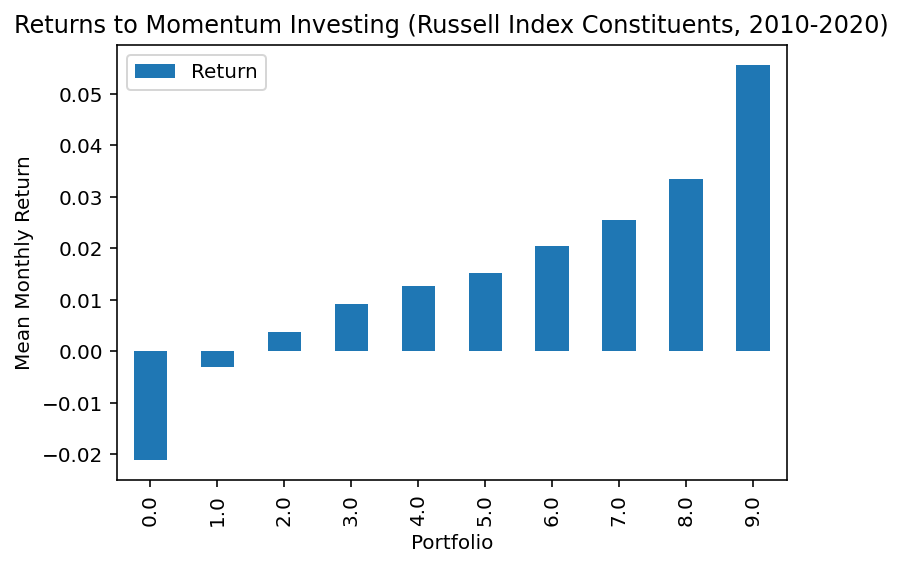

In [9]:
(
    pd.concat([ret_1m, port_12m], axis=1, keys=['Return', 'Portfolio'])
    .stack()
    .loc['2010':'2020']
    .groupby('Portfolio')
    .mean()
    .plot(kind='bar')
)
plt.ylabel('Mean Monthly Return')
plt.title('Returns to Momentum Investing (Russell Index Constituents, 2010-2020)')
plt.show()

We will skip 1 month between assigning stocks to portfolios and buying the stocks to avoid market-microstructure stock issues (i.e., noise in returns due to how stocks trade).
Our dates are end-of-month, so we need a two-month gap between the ranking month and the holding month.

## Calculate portfolio returns

We will equally weight the stocks in each portfolio because equal-weighting does not require any information and is easy with the `.mean()` method.
Relative to value-weighting (also known as market-capitalization-weight), equal-equal overweights small stocks (i.e., stocks with low market capitalizations).
Again, if time permits, we will investigate momentum investing with value-weighting.
In general, anomaly findings are larger with equal-weighted portfolios than with value-weighted portfolios because more sophisticated investors more heavily trade large stocks (i.e., stocks with high market capitalizations). 
Both of these channels tend to weaken anomalies.

## Evaluate average performance

## Evaluate cumulative performance